# Woods strategy

In [70]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, 
                               FormatStrFormatter, 
                               AutoMinorLocator) 

from lcs import Perception
from lcs.agents import EnvironmentAdapter
from lcs.metrics import population_metrics

import lcs.agents.acs2 as acs2
import lcs.agents.aacs2 as aacs2
import lcs.agents.acs2ar as acs2ar

import random
from collections import namedtuple

# Logger
import logging
logging.basicConfig(level=logging.INFO)

import gym_woods
woods1 = gym.make('Woods1-v0')
woods2 = gym.make('Woods2-v0')
woods14 = gym.make('Woods14-v0')

In [2]:
class WoodsAdapter(EnvironmentAdapter):

    @classmethod
    def to_genotype(cls, phenotype):
        result = []
        for el in phenotype:
            if el == 'F':
                result.extend(['1', '1', '0'])
            if el == 'G':
                result.extend(['1', '1', '1'])
            if el == 'O':
                result.extend(['0', '1', '0'])
            if el == 'Q':
                result.extend(['0', '1', '1'])
            if el == '.':
                result.extend(['0', '0', '0'])

        return result

In [3]:
def common_metrics(agent, env):
    pop = agent.get_population()

    metrics = {
        'agent': agent.__class__.__name__,
        'reliable': len([cl for cl in pop if cl.is_reliable()]),
    }

    if hasattr(agent, 'rho'):
        metrics['rho'] = agent.rho
    else:
        metrics['rho'] = 0

    metrics.update(population_metrics(pop, env))
    return metrics

In [4]:
def parse_metrics(metrics):
    idx = [d['agent'] for d in metrics]

    data = [[
        d['trial'],
        d['steps_in_trial'],
        d['rho'],
        d['population'],
        d['reliable']] for d in metrics]

    df = pd.DataFrame(
        data,
        columns=['trial', 'steps_in_trial', 'rho', 'population', 'reliable'],
        index=idx
    )

    df['phase'] = df.trial.map(
        lambda t: "explore" if t % 2 == 0 else "exploit")
    
    return df

Train the ACS2 agent

In [5]:
env = woods1

env.reset()
env.render()


□ □ □ X □
□ ■ ■ $ □
□ ■ ■ ■ □
□ ■ ■ ■ □
□ □ □ □ □


In [6]:
state_to_actions = env.env._state_action()
state_to_actions

{('0', '0'): [0, 1, 2, 4, 5, 6, 7],
 ('1', '0'): [0, 1, 2, 5, 6, 7],
 ('2', '0'): [0, 1, 2, 3, 6, 7],
 ('3', '0'): [0, 1, 2, 3, 4, 6, 7],
 ('4', '0'): [0, 1, 2, 3, 4, 5, 6, 7],
 ('0', '1'): [0, 1, 4, 5, 6, 7],
 ('4', '1'): [0, 1, 2, 3, 4, 6, 7],
 ('0', '2'): [0, 4, 5, 6, 7],
 ('4', '2'): [0, 1, 2, 3, 4, 7],
 ('0', '3'): [0, 3, 4, 5, 6, 7],
 ('4', '3'): [0, 1, 2, 3, 4, 5],
 ('0', '4'): [0, 2, 3, 4, 5, 6, 7],
 ('1', '4'): [2, 3, 4, 5, 6, 7],
 ('2', '4'): [2, 3, 4, 5, 6],
 ('3', '4'): [1, 2, 3, 4, 5, 6],
 ('4', '4'): [0, 1, 2, 3, 4, 5, 6]}

In [7]:
PerceptionAction = namedtuple('PerceptionAction', 'id perception action')

state_action = []

idx = 1
for state, actions in state_to_actions.items():
    if len(actions) > 0:
        for action in actions:
            perception = env.env._perception(int(state[0]), int(state[1]))
            state_action.append(PerceptionAction(idx, perception, action))
            idx += 1
        
# print first few records        
state_action[:10]

[PerceptionAction(id=1, perception=['.', '.', '.', 'O', '.', '.', '.', '.'], action=0),
 PerceptionAction(id=2, perception=['.', '.', '.', 'O', '.', '.', '.', '.'], action=1),
 PerceptionAction(id=3, perception=['.', '.', '.', 'O', '.', '.', '.', '.'], action=2),
 PerceptionAction(id=4, perception=['.', '.', '.', 'O', '.', '.', '.', '.'], action=4),
 PerceptionAction(id=5, perception=['.', '.', '.', 'O', '.', '.', '.', '.'], action=5),
 PerceptionAction(id=6, perception=['.', '.', '.', 'O', '.', '.', '.', '.'], action=6),
 PerceptionAction(id=7, perception=['.', '.', '.', 'O', '.', '.', '.', '.'], action=7),
 PerceptionAction(id=8, perception=['.', '.', '.', 'O', 'O', '.', '.', '.'], action=0),
 PerceptionAction(id=9, perception=['.', '.', '.', 'O', 'O', '.', '.', '.'], action=1),
 PerceptionAction(id=10, perception=['.', '.', '.', 'O', 'O', '.', '.', '.'], action=2)]

In [8]:
# create a dict id > perception (for q-learning)

sp = {idx: env.env._perception(int(i[0][0]), int(i[0][1])) for idx, i in enumerate(state_to_actions.items())}
sp

{0: ['.', '.', '.', 'O', '.', '.', '.', '.'],
 1: ['.', '.', '.', 'O', 'O', '.', '.', '.'],
 2: ['.', '.', '.', 'F', 'O', 'O', '.', '.'],
 3: ['.', '.', '.', '.', 'F', 'O', '.', '.'],
 4: ['.', '.', '.', '.', '.', 'F', '.', '.'],
 5: ['.', '.', 'O', 'O', '.', '.', '.', '.'],
 6: ['.', '.', '.', '.', '.', 'O', 'F', '.'],
 7: ['.', 'O', 'O', 'O', '.', '.', '.', '.'],
 8: ['.', '.', '.', '.', '.', 'O', 'O', 'F'],
 9: ['.', 'O', 'O', '.', '.', '.', '.', '.'],
 10: ['.', '.', '.', '.', '.', '.', 'O', 'O'],
 11: ['.', 'O', '.', '.', '.', '.', '.', '.'],
 12: ['O', 'O', '.', '.', '.', '.', '.', '.'],
 13: ['O', 'O', '.', '.', '.', '.', '.', 'O'],
 14: ['O', '.', '.', '.', '.', '.', '.', 'O'],
 15: ['.', '.', '.', '.', '.', '.', '.', 'O']}

In [9]:
def find_obs_id(p):
    for idx, perception in sp.items():
        if perception == p:
            return idx
    
    return None

# p = env.env._perception(0, 2)
# find_id(p)

## Experiments

In [95]:
learning_rate = 0.8
discount_factor = 0.95
epsilon = 0.1
zeta = 0.0001

In [11]:
%%time

cfg = acs2.Configuration(8, 8,
                         do_ga=True,
                         beta=learning_rate,
                         gamma=discount_factor,
                         epsilon=1-epsilon,
                         user_metrics_collector_fcn=common_metrics,
                         biased_exploration_prob=0.5,
                         metrics_trial_frequency=1)


agent = acs2.ACS2(cfg)
acs2_population, acs2_metrics = agent.explore(env, 10_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 5, 'reward': 1000, 'agent': 'ACS2', 'reliable': 0, 'rho': 0, 'population': 4, 'numerosity': 4}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 11, 'reward': 1000, 'agent': 'ACS2', 'reliable': 187, 'rho': 0, 'population': 200, 'numerosity': 2023}
INFO:lcs.agents.Agent:{'trial': 2000, 'steps_in_trial': 18, 'reward': 1000, 'agent': 'ACS2', 'reliable': 164, 'rho': 0, 'population': 175, 'numerosity': 2034}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 1, 'reward': 1000, 'agent': 'ACS2', 'reliable': 163, 'rho': 0, 'population': 182, 'numerosity': 2037}
INFO:lcs.agents.Agent:{'trial': 4000, 'steps_in_trial': 23, 'reward': 1000, 'agent': 'ACS2', 'reliable': 163, 'rho': 0, 'population': 177, 'numerosity': 2033}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 6, 'reward': 1000, 'agent': 'ACS2', 'reliable': 157, 'rho': 0, 'population': 172, 'numerosity': 2031}
INFO:lcs.agents.Agent:{'trial': 6000, 'steps_in_trial': 3, 

CPU times: user 3min 9s, sys: 1.19 s, total: 3min 10s
Wall time: 3min 14s


In [12]:
from copy import copy

acs2_exploiter = acs2.ACS2(cfg, copy(acs2_population))
acs2_explt_population, acs2_explt_metrics = acs2_exploiter.exploit(env, 100)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 15, 'reward': 1000, 'agent': 'ACS2', 'reliable': 156, 'rho': 0, 'population': 170, 'numerosity': 2036}
INFO:lcs.agents.Agent:{'trial': 10, 'steps_in_trial': 17, 'reward': 1000, 'agent': 'ACS2', 'reliable': 156, 'rho': 0, 'population': 170, 'numerosity': 2036}
INFO:lcs.agents.Agent:{'trial': 20, 'steps_in_trial': 22, 'reward': 1000, 'agent': 'ACS2', 'reliable': 156, 'rho': 0, 'population': 170, 'numerosity': 2036}
INFO:lcs.agents.Agent:{'trial': 30, 'steps_in_trial': 5, 'reward': 1000, 'agent': 'ACS2', 'reliable': 156, 'rho': 0, 'population': 170, 'numerosity': 2036}
INFO:lcs.agents.Agent:{'trial': 40, 'steps_in_trial': 3, 'reward': 1000, 'agent': 'ACS2', 'reliable': 156, 'rho': 0, 'population': 170, 'numerosity': 2036}
INFO:lcs.agents.Agent:{'trial': 50, 'steps_in_trial': 6, 'reward': 1000, 'agent': 'ACS2', 'reliable': 156, 'rho': 0, 'population': 170, 'numerosity': 2036}
INFO:lcs.agents.Agent:{'trial': 60, 'steps_in_trial': 2, 'rewa

In [69]:
%%time

# AACS2
aacs2_cfg = aacs2.Configuration(8, 8,
                                do_ga=True,
                                beta=learning_rate,
                                epsilon=1-epsilon,
                                zeta=zeta,
                                gamma=discount_factor,
                                user_metrics_collector_fcn=common_metrics,
                                biased_exploration_prob=0.2)

aacs2_agent = aacs2.AACS2(aacs2_cfg)
aacs2_population, aacs2_metrics = aacs2_agent.explore_exploit(env, 200_000)

# worked for 200k with GA=false

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 4, 'reward': 1000, 'agent': 'AACS2', 'reliable': 0, 'rho': 0, 'population': 4, 'numerosity': 4}
INFO:lcs.agents.Agent:{'trial': 20000, 'steps_in_trial': 2, 'reward': 1000, 'agent': 'AACS2', 'reliable': 158, 'rho': 478.94569381310845, 'population': 180, 'numerosity': 2073}
INFO:lcs.agents.Agent:{'trial': 40000, 'steps_in_trial': 2, 'reward': 1000, 'agent': 'AACS2', 'reliable': 150, 'rho': 494.46010418129947, 'population': 163, 'numerosity': 2103}
INFO:lcs.agents.Agent:{'trial': 60000, 'steps_in_trial': 27, 'reward': 1000, 'agent': 'AACS2', 'reliable': 145, 'rho': 488.26868510992375, 'population': 164, 'numerosity': 2118}
INFO:lcs.agents.Agent:{'trial': 80000, 'steps_in_trial': 11, 'reward': 1000, 'agent': 'AACS2', 'reliable': 140, 'rho': 488.93121726213445, 'population': 155, 'numerosity': 2106}
INFO:lcs.agents.Agent:{'trial': 100000, 'steps_in_trial': 3, 'reward': 1000, 'agent': 'AACS2', 'reliable': 140, 'rho': 489.4278741136652, 'po

CPU times: user 24min 28s, sys: 3.12 s, total: 24min 31s
Wall time: 24min 36s


In [64]:
%%time
# This one seems to be wrong

acs2ar_cfg = acs2ar.Configuration(8, 8,
                                  do_ga=True,
                                  beta=learning_rate,
                                  epsilon=1-epsilon,
                                  gamma=discount_factor,
                                  zeta=zeta,
                                  biased_exploration_prob=0.2)


acs2ar_agent = acs2ar.ACS2AR(aacs2_cfg)
acs2ar_population, acs2ar_metrics = acs2ar_agent.explore_exploit(env, 1000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 2, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 0, 'rho': 0, 'population': 2, 'numerosity': 2}
INFO:lcs.agents.Agent:{'trial': 500, 'steps_in_trial': 8, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 292, 'rho': -50.51775551629377, 'population': 316, 'numerosity': 1582}
INFO:lcs.agents.Agent:{'trial': 1000, 'steps_in_trial': 50, 'reward': 0, 'agent': 'ACS2AR', 'reliable': 178, 'rho': -8756.792854526173, 'population': 192, 'numerosity': 1733}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 11, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 176, 'rho': -1883307.6225288545, 'population': 196, 'numerosity': 1796}
INFO:lcs.agents.Agent:{'trial': 2000, 'steps_in_trial': 43, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 169, 'rho': -323986599.0247179, 'population': 182, 'numerosity': 1857}
INFO:lcs.agents.Agent:{'trial': 2500, 'steps_in_trial': 3, 'reward': 1000, 'agent': 'ACS2AR', 'reliable': 163, 'rho': -62951942969.65098, 'pop

CPU times: user 3min 38s, sys: 1.18 s, total: 3min 39s
Wall time: 3min 50s


## Q-learning

In [13]:
%%time

Q = np.zeros((len(sp), env.action_space.n))
episodes = 5000

for i in range(1, episodes):
#     print("\nNEW EPISODE")
    obs = env.reset()
    state = find_obs_id(obs)
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
            
        next_obs, reward, done, info = env.step(action)
        next_state = find_obs_id(next_obs)
        
        if next_state is not None:
            discounted = np.max(Q[next_state, :])
        else:
            discounted = 0
        
        Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * discounted - Q[state, action])
        
#         print(f"{state} == ({action}) ==> {next_state} (r: {reward})\tQ[{state}, {action}]: {Q[state, action]}")
        state = next_state

Q

CPU times: user 812 ms, sys: 9.68 ms, total: 822 ms
Wall time: 849 ms


array([[ 857.375     ,  900.0062213 ,  798.56498942,  902.00757898,
         902.5       ,  950.        ,  923.2442    ,  850.516     ],
       [ 902.5       ,  892.4642    ,  760.        ,  847.84099   ,
         857.29872792,  858.08256   ,  855.72884   ,  866.4       ],
       [ 902.49999817,  902.48335204,  950.        , 1000.        ,
         949.99996987,  949.99997198,  857.37495486,  902.49999965],
       [ 902.49955747,  902.49999999,  949.9697946 ,  949.99915224,
        1000.        ,  949.99999389,  949.99997553,  892.46419988],
       [ 902.5       ,  900.69280512,  900.34954784,  902.430688  ,
         948.48      , 1000.        ,  905.92      ,  902.4854722 ],
       [ 848.80124956,  823.08      ,  902.4489055 ,  901.713742  ,
         902.5       ,  948.48      ,  950.        ,  949.99967508],
       [ 949.99873219,  902.49980701,  902.4976896 ,  902.5       ,
         949.99990272,  949.997568  , 1000.        ,  949.99984722],
       [ 900.02402494,  902.4976896 ,  90

In [96]:
# learning_rate = 0.1

def rlearning(env, episodes=5000):
    R = np.zeros((len(sp), env.action_space.n))
    rho = 0

    for i in range(1, episodes):
        state = find_obs_id(env.reset())
        was_greedy = False
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(R[state, :])
                was_greedy = True

            next_obs, reward, done, info = env.step(action)
            next_state = find_obs_id(next_obs)

            if next_state is not None:
                discounted = np.max(R[next_state, :])
            else:
                discounted = 0
            
            R[state, action] = R[state, action] + learning_rate * (reward - rho + discounted - R[state, action])

            if was_greedy:
                rho = rho + zeta * (reward + np.max(R[next_state, :]) - discounted - rho)

            state = next_state 
    
    return R, rho

def avg(matrices):
    X = sum(matrices)
    X /= len(matrices)
    return X

In [100]:
# perform r-learning
experiments = 10
Rs = []
rhos = []

for i in range(0, experiments):
    print(f"Performing experiment {i}")
    R, rho = rlearning(env)
    
    Rs.append(R)
    rhos.append(rho)
    
R = avg(Rs)
rho = np.mean(rhos)

print(f"\nRho: {rho}\n")
# print(R)

Performing experiment 0
Performing experiment 1
Performing experiment 2
Performing experiment 3
Performing experiment 4
Performing experiment 5
Performing experiment 6
Performing experiment 7
Performing experiment 8
Performing experiment 9

Rho: 531.7041015243077



## Payoff landscape

In [101]:
payoffs = {}

acs2_rewards = []

for sa in state_action:
    p = Perception(sa.perception)
    
    # ACS2
    acs2_match_set = acs2_population.form_match_set(p)
    acs2_action_set = acs2_match_set.form_action_set(sa.action)

    # AACS2
    aacs2_match_set = aacs2_population.form_match_set(p)
    aacs2_action_set = aacs2_match_set.form_action_set(sa.action)
    
    # ACS2AR
    acs2ar_match_set = acs2ar_population.form_match_set(p)
    acs2ar_action_set = acs2ar_match_set.form_action_set(sa.action)
    
    for alg, action_set in zip(['ACS2', 'AACS2', 'ACS2AR'], [acs2_action_set, aacs2_action_set, acs2ar_action_set]):
        if len(action_set) == 0:
            print(f"WARN: No {alg} classifiers for state: {find_obs_id(sa.perception)}, action: {sa.action}")
    
    payoffs[sa.id] = {
        'acs2': np.mean(list(map(lambda cl: cl.r, acs2_action_set))),
        'aacs2': np.mean(list(map(lambda cl: cl.r, aacs2_action_set))),
        'acs2ar': np.mean(list(map(lambda cl: cl.r, acs2ar_action_set))),
        'q-learning': Q[find_obs_id(sa.perception), sa.action],
        'r-learning': R[find_obs_id(sa.perception), sa.action],
    }

WARN: No ACS2AR classifiers for state: 0, action: 4
WARN: No ACS2AR classifiers for state: 11, action: 2
WARN: No ACS2AR classifiers for state: 11, action: 7
WARN: No ACS2AR classifiers for state: 15, action: 3
WARN: No ACS2AR classifiers for state: 15, action: 6


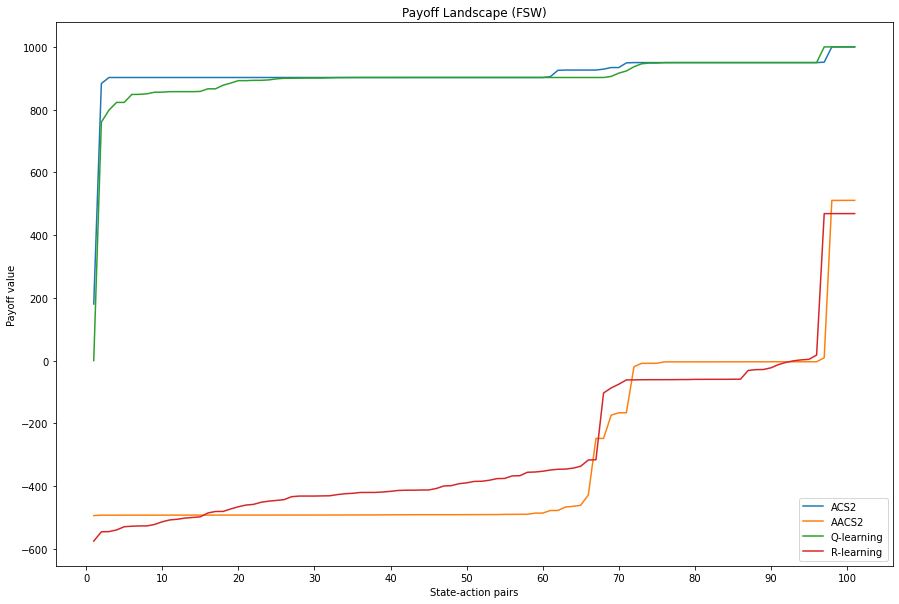

In [102]:
fig, ax = plt.subplots(figsize=(15, 10))

x = range(1, len(payoffs)+1)
y_acs2 = sorted([v['acs2'] for k, v in payoffs.items()])
y_aacs2 = sorted([v['aacs2'] for k, v in payoffs.items()])
y_acs2ar = sorted([v['acs2ar'] for k, v in payoffs.items()])
y_qlearning = sorted([v['q-learning'] for k, v in payoffs.items()])
y_rlearning = sorted([v['r-learning'] for k, v in payoffs.items()])


# ACS2
# plt.scatter(x, y_acs2)
plt.plot(x, y_acs2, label='ACS2')

# AACS2
# plt.scatter(x, y_aacs2)
plt.plot(x, y_aacs2, label='AACS2')

# ACS2AR
# plt.scatter(x, y_aacs2)
# plt.plot(x, y_acs2ar, label='ACS2AR')

# Q-learning
# plt.scatter(x, y_qlearning)
plt.plot(x, y_qlearning, label='Q-learning')

# R-learning
# plt.scatter(x, y_qlearning)
plt.plot(x, y_rlearning, label='R-learning')

ax.xaxis.set_major_locator(MultipleLocator(10)) 
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 

ax.set_xlabel("State-action pairs")
ax.set_ylabel("Payoff value")
ax.set_title("Payoff Landscape (FSW)")

ax.legend(loc='lower right')

plt.show()

## Steps to reward

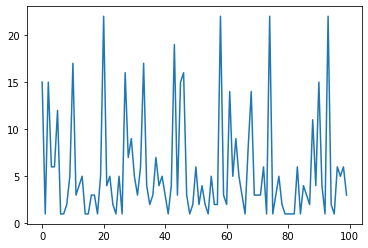

In [16]:
m = parse_metrics(acs2_explt_metrics)

plt.plot(m['trial'], m['steps_in_trial'])
plt.show()

In [17]:
m['steps_in_trial'].mean()

5.61